In [3]:
import fitz 
import io    
from PIL import Image 


In [4]:
file = "./Textbook of Plastic, Reconstructive, and Aesthetic Surgery -- Karoon Agrawal, Kuldeep Singh, Lokesh Kumar -- VI, 2021 -- Thieme .pdf"

In [7]:
pdf_file = fitz.open(file)
len(pdf_file)

848

In [11]:
for page_index in range(10, len(pdf_file)): 
  
    # get the page itself 
    page = pdf_file[page_index] 
    print(page)
    image_list = page.getImageList() 
  
    # printing number of images found in this page 
    if image_list: 
        print( 
            f"[+] Found a total of {len(image_list)} images in page {page_index}") 
    else: 
        print("[!] No images found on page", page_index) 
    for image_index, img in enumerate(page.getImageList(), start=1): 
  
        # get the XREF of the image 
        xref = img[0] 
  
        # extract the image bytes 
        base_image = pdf_file.extractImage(xref) 
        image_bytes = base_image["image"] 
  
        # get the image extension 
        image_ext = base_image["ext"]

page 10 of ./Textbook of Plastic, Reconstructive, and Aesthetic Surgery -- Karoon Agrawal, Kuldeep Singh, Lokesh Kumar -- VI, 2021 -- Thieme .pdf


AttributeError: 'Page' object has no attribute 'getImageList'

In [ ]:
import sys, fitz  # import the bindings
file = "./pdf.pdf"
doc = fitz.open(file)  # open document
for page in doc:  # iterate through the pages
    pix = page.get_pixmap(dpi=300)  # render page to an image
    pix.save("images/page-%i.png" % page.number)  # store image as a PNG

In [28]:
import easyocr

reader = easyocr.Reader(['en']) # specify the language  
result = reader.readtext('images/page-47.png')

for (bbox, text, prob) in result:
    print(f'Text: {text}, Probability: {prob}')

Text: 24, Probability: 0.9999980612455189
Text: General, Probability: 0.9999941426005419
Text: Annexure 2.1, Probability: 0.9985888446767553
Text: Indian Medical Council (Professional Conduct; Etiquette and Ethics), Probability: 0.8021522477397002
Text: Regulations, 2002, Probability: 0.8929933319575
Text: 6.1.1, Probability: 0.999635924425985
Text: Soliciting of patients directly or indirectly, by a phy-, Probability: 0.9523918020674149
Text: On changing address., Probability: 0.7682554770867182
Text: sician; by a group of physicians, or by institutions Or organi-, Probability: 0.5357360159133605
Text: On temporary absence from duty:, Probability: 0.8053836475032469
Text: zations is unethical A physician shall not make use of him], Probability: 0.8017191365666888
Text: On resumption of another practice, Probability: 0.9063513510528234
Text: her (Or his/her name) as subject of any form O manner of, Probability: 0.6999142672033041
Text: On, Probability: 0.9998425430050173
Text: succeedi

In [12]:
# import the necessary packages
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from pytesseract import Output
from tabulate import tabulate
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2

In [13]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [15]:
args = {
	"image": "images/page-47.png",
	"output": "results.csv",
	"min_conf": 0,
	"dist_thresh": 25.0,
	"min_size": 2,
}


In [18]:
# set a seed for our random number generator
np.random.seed(42)

# load the input image and convert it to grayscale
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

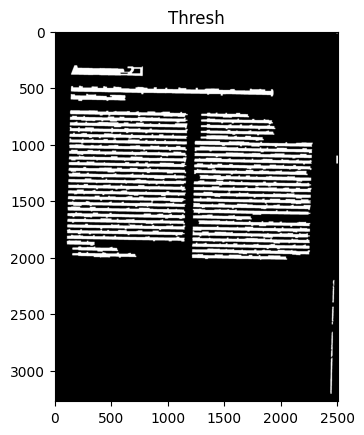

In [19]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

# compute the Scharr gradient of the blackhat image and scale the result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")

# apply a closing operation using the rectangular kernel to close gaps in between characters, 
#apply Otsu's thresholding method, and finally a dilation operation to enlarge foreground regions
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)
plt_imshow("Thresh", thresh)

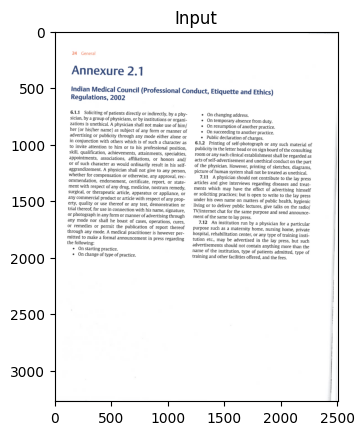

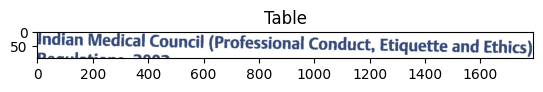

In [20]:
# find contours in the thresholded image and grab the largest one,
# which we will assume is the stats table
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
tableCnt = max(cnts, key=cv2.contourArea)

# compute the bounding box coordinates of the stats table and extract
# the table from the input image
(x, y, w, h) = cv2.boundingRect(tableCnt)
table = image[y:y + h, x:x + w]

# show the original input image and extracted table to our screen
plt_imshow("Input", image)
plt_imshow("Table", table)

In [22]:
# Set the PSM mode to detect sparse text, and then localize text in the table
options = "--psm 6"
results = pytesseract.image_to_data(
	cv2.cvtColor(table, cv2.COLOR_BGR2RGB),
	config=options,
	output_type=Output.DICT)

# Initialize a list to store the (x, y)-coordinates of the detected text along with the OCR'd text itself
coords = []
ocrText = []

# loop over each of the individual text localizations
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
	x = results["left"][i]
	y = results["top"][i]
	w = results["width"][i]
	h = results["height"][i]

	# extract the OCR text itself along with the confidence of the
	# text localization
	text = results["text"][i]
	conf = int(float(results["conf"][i]))

	# filter out weak confidence text localizations
	if conf > args["min_conf"]:
		# update our text bounding box coordinates and OCR'd text,
		# respectively
		coords.append((x, y, w, h))
		ocrText.append(text)

In [26]:
# Extract all x-coordinates from the text bounding boxes, setting the y-coordinate value to zero
xCoords = [(c[0], 0) for c in coords]

# Apply hierarchical agglomerative clustering to the coordinates
clustering = AgglomerativeClustering(
	n_clusters=None,
    metric='euclidean',
	linkage="complete",
	distance_threshold=args["dist_thresh"])
clustering.fit(xCoords)

AgglomerativeClustering(distance_threshold=25.0, linkage='complete',
                        n_clusters=None)

In [27]:
# Initialize our list of sorted clusters
sortedClusters = []

# loop over all clusters
for l in np.unique(clustering.labels_):
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# verify that the cluster is sufficiently large
	if len(idxs) > args["min_size"]:
		# compute the average x-coordinate value of the cluster and
		# update our clusters list with the current label and the
		# average x-coordinate
		avg = np.average([coords[i][0] for i in idxs])
		sortedClusters.append((l, avg))

# sort the clusters by their average x-coordinate and initialize our
# data frame
sortedClusters.sort(key=lambda x: x[1])
df = pd.DataFrame()

In [29]:
# loop over the clusters again, this time in sorted order
for (l, _) in sortedClusters:
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# extract the y-coordinates from the elements in the current
	# cluster, then sort them from top-to-bottom
	yCoords = [coords[i][1] for i in idxs]
	sortedIdxs = idxs[np.argsort(yCoords)]

	# generate a random color for the cluster
	color = np.random.randint(0, 255, size=(3,), dtype="int")
	color = [int(c) for c in color]

	# loop over the sorted indexes
	for i in sortedIdxs:
		# extract the text bounding box coordinates and draw the
		# bounding box surrounding the current element
		(x, y, w, h) = coords[i]
		cv2.rectangle(table, (x, y), (x + w, y + h), color, 2)

	# extract the OCR'd text for the current column, then construct
	# a data frame for the data where the first entry in our column
	# serves as the header
	cols = [ocrText[i].strip() for i in sortedIdxs]
	currentDF = pd.DataFrame({cols[0]: cols[1:]})

	# concatenate *original* data frame with the *current* data
	# frame (we do this to handle columns that may have a varying
	# number of rows)
	df = pd.concat([df, currentDF], axis=1)

In [32]:
# replace NaN values with an empty string and then show a nicely
# formatted version of our multi-column OCR'd text
df.fillna("", inplace=True)
print(tabulate(df, headers="keys", tablefmt="psql"))

[INFO] saving CSV file to disk...


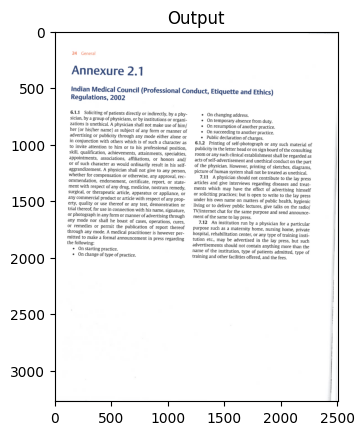

In [31]:
# write our table to disk as a CSV file
print("[INFO] saving CSV file to disk...")
df.to_csv(args["output"], index=False)

# show the output image after performing multi-column OCR
plt_imshow("Output", image)

In [37]:
import cv2
import sys

SCALE = 4
AREA_THRESHOLD = 427505.0 / 2

def show_scaled(name, img):
    try:
        h, w  = img.shape
    except ValueError:
        h, w, _  = img.shape
    cv2.imshow(name, cv2.resize(img, (w // SCALE, h // SCALE)))

def main():
    img = cv2.imread(sys.argv[1])
    img = img[10:-10, 10:-10] # remove the border, it confuses contour detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    show_scaled("original", gray)

    # black and white, and inverted, because
    # white pixels are treated as objects in
    # contour detection
    thresholded = cv2.adaptiveThreshold(
                gray, 255,
                cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,
                25,
                15
            )
    show_scaled('thresholded', thresholded)
    # I use a kernel that is wide enough to connect characters
    # but not text blocks, and tall enough to connect lines.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 33))
    closing = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

    im2, contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    show_scaled("closing", closing)

    for contour in contours:
        convex_contour = cv2.convexHull(contour)
        area = cv2.contourArea(convex_contour)
        if area > AREA_THRESHOLD:
            cv2.drawContours(img, [convex_contour], -1, (255,0,0), 3)

    show_scaled("contours", img)
    cv2.imwrite("images/page-47.png", img)
    cv2.waitKey()


main()

[ WARN:0@1905.614] global loadsave.cpp:248 findDecoder imread_('--f=/home/raj/.local/share/jupyter/runtime/kernel-v2-165130pmLVQizKfAx.json'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable